In [1]:
import pandas as pd

# Load the dataset
file_path = 'tugas3_genap.csv'
df = pd.read_csv(file_path)

# Display the first few rows to understand the data
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [2]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
import numpy as np

# Identifikasi kolom kategorikal
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
categorical_cols.remove('deposit')  # deposit adalah target
categorical_cols


['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome']

In [11]:
df_processed = df.copy()

df_processed = pd.get_dummies(df_processed, columns=['job'])

label_encoder = LabelEncoder()
df_processed['marital'] = label_encoder.fit_transform(df_processed['marital'])

education_order = [['primary', 'secondary', 'tertiary', 'unknown']]
ordinal_encoder = OrdinalEncoder(categories=education_order)
df_processed['education'] = ordinal_encoder.fit_transform(df_processed[['education']])

bins = [0, 30, 45, 60, np.inf]
labels = ['Muda', 'Dewasa', 'Paruh Baya', 'Lanjut Usia']
df_processed['age_group'] = pd.cut(df_processed['age'], bins=bins, labels=labels)

df_processed[['age', 'age_group', 'marital', 'education']].head()


,age,age_group,marital,education
0,59,Paruh Baya,1,1.0
1,56,Paruh Baya,1,1.0
2,41,Dewasa,1,1.0
3,55,Paruh Baya,1,1.0
4,54,Paruh Baya,1,2.0


In [4]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Min-Max Scaling pada 'balance'
min_max_scaler = MinMaxScaler()
df_processed['balance_minmax'] = min_max_scaler.fit_transform(df_processed[['balance']])

# Z-Score Scaling pada 'duration'
zscore_scaler = StandardScaler()
df_processed['duration_zscore'] = zscore_scaler.fit_transform(df_processed[['duration']])

# Decimal Scaling pada 'campaign'
max_abs_campaign = df_processed['campaign'].abs().max()
scaling_factor = 10 ** len(str(int(max_abs_campaign)))
df_processed['campaign_decimal'] = df_processed['campaign'] / scaling_factor

# Tampilkan hasil normalisasi
df_processed[['balance', 'balance_minmax', 'duration', 'duration_zscore', 'campaign', 'campaign_decimal']].head()


,balance,balance_minmax,duration,duration_zscore,campaign,campaign_decimal
0,2343,0.104371,1042,1.930226,1,0.01
1,45,0.078273,1467,3.154612,1,0.01
2,1270,0.092185,1389,2.929901,1,0.01
3,2476,0.105882,579,0.596366,1,0.01
4,184,0.079851,673,0.867171,2,0.02


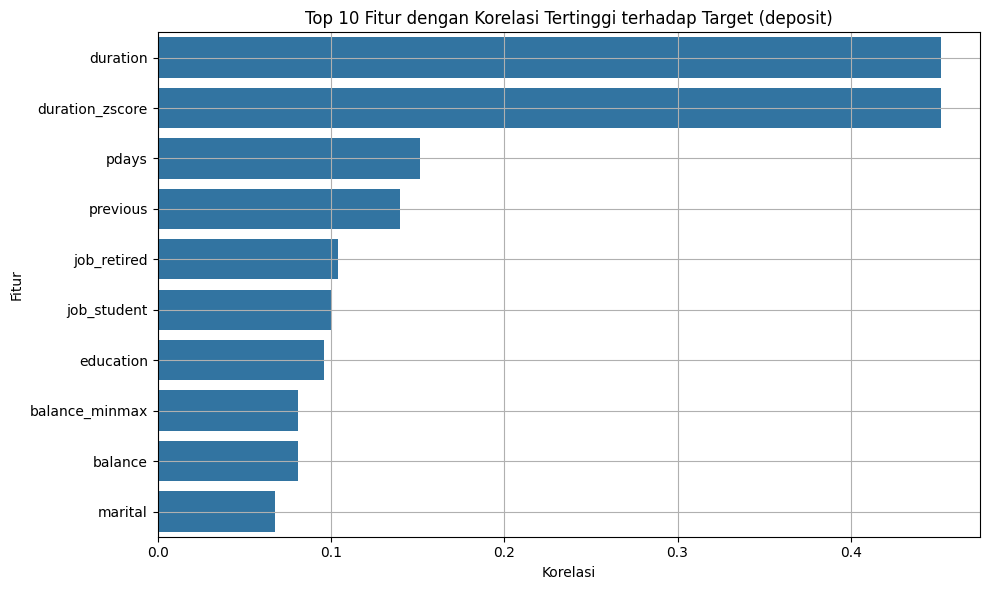

duration           0.451919
duration_zscore    0.451919
pdays              0.151593
previous           0.139867
job_retired        0.103827
job_student        0.099953
education          0.095948
balance_minmax     0.081129
balance            0.081129
marital            0.067610
Name: deposit, dtype: float64

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Encode target 'deposit' menjadi numerik: yes = 1, no = 0
df_processed['deposit'] = df_processed['deposit'].map({'yes': 1, 'no': 0})

# Hitung korelasi semua fitur numerik terhadap target 'deposit'
correlations = df_processed.corr(numeric_only=True)['deposit'].sort_values(ascending=False)

# Tampilkan fitur dengan korelasi tertinggi (positif dan negatif)
top_correlated_features = correlations.drop('deposit').head(10)

# Visualisasi korelasi
plt.figure(figsize=(10, 6))
sns.barplot(x=top_correlated_features.values, y=top_correlated_features.index)
plt.title('Top 10 Fitur dengan Korelasi Tertinggi terhadap Target (deposit)')
plt.xlabel('Korelasi')
plt.ylabel('Fitur')
plt.grid(True)
plt.tight_layout()
plt.show()

top_correlated_features


In [7]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Pilih hanya fitur numerik untuk PCA
numeric_features = df_processed.select_dtypes(include=[np.number]).drop(columns=['deposit'])

# Standarisasi fitur numerik sebelum PCA
scaler = StandardScaler()
scaled_features = scaler.fit_transform(numeric_features)

# PCA untuk mereduksi menjadi 5 fitur utama
pca = PCA(n_components=5)
pca_components = pca.fit_transform(scaled_features)

# Simpan hasil PCA ke dataframe
pca_df = pd.DataFrame(pca_components, columns=[f'PCA_{i+1}' for i in range(5)])
pca_df.head()


,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5
0,-2.176085,0.282936,2.024825,-1.308777,0.318946
1,-2.607668,-0.533352,3.784583,-1.134749,0.591204
2,-2.599140,-0.300469,3.422333,-0.401372,0.086097
3,-1.268601,0.177923,0.399136,-1.258956,-0.023933
4,-0.695993,-0.412160,1.101833,-0.748739,0.068520


In [8]:
from sklearn.model_selection import train_test_split

# Gabungkan fitur hasil PCA dan target
final_df = pca_df.copy()
final_df['deposit'] = df_processed['deposit']

# Pisahkan fitur dan target
X = final_df.drop(columns='deposit')
y = final_df['deposit']

# Split Train (70%) dan Temp (30%) dengan stratifikasi
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Split Temp menjadi Validation (15%) dan Test (15%) → dari total data
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# Cek distribusi target di tiap subset
train_dist = y_train.value_counts(normalize=True)
val_dist = y_val.value_counts(normalize=True)
test_dist = y_test.value_counts(normalize=True)

train_dist, val_dist, test_dist


(deposit
 0    0.526174
 1    0.473826
 Name: proportion, dtype: float64,
 deposit
 0    0.526284
 1    0.473716
 Name: proportion, dtype: float64,
 deposit
 0    0.52597
 1    0.47403
 Name: proportion, dtype: float64)

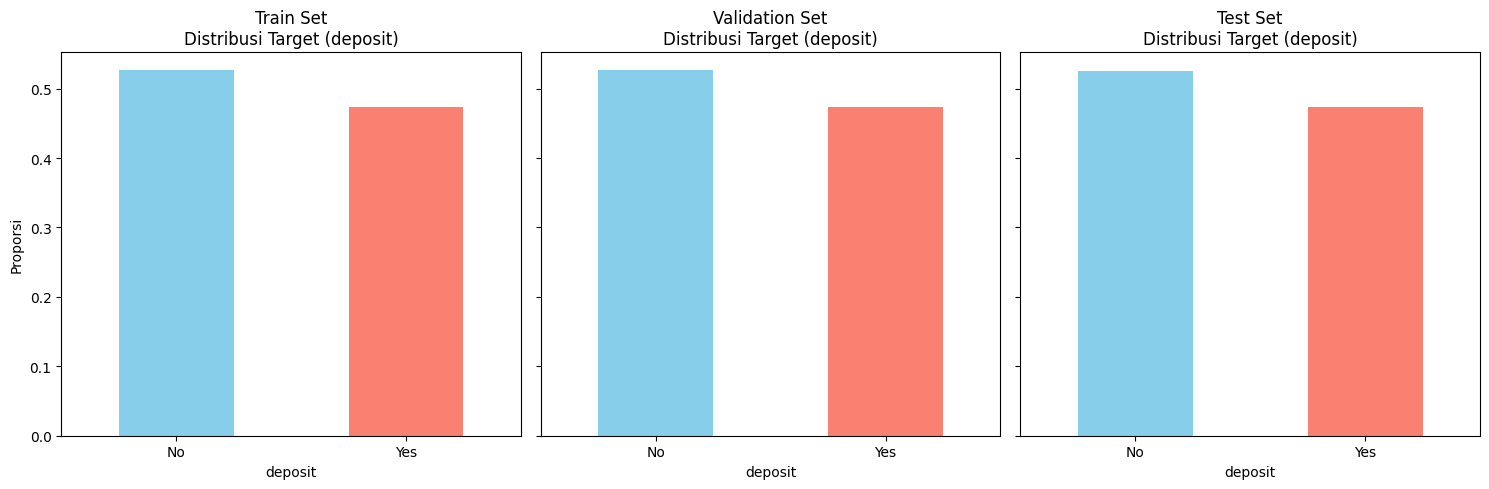

In [9]:
import matplotlib.pyplot as plt

# Visualisasi distribusi target di tiap subset
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

datasets = {'Train': y_train, 'Validation': y_val, 'Test': y_test}
colors = ['skyblue', 'salmon']

for ax, (name, data) in zip(axes, datasets.items()):
    data.value_counts(normalize=True).plot(
        kind='bar',
        ax=ax,
        color=colors,
        title=f'{name} Set\nDistribusi Target (deposit)',
        rot=0
    )
    ax.set_ylabel('Proporsi')
    ax.set_xticklabels(['No', 'Yes'])

plt.tight_layout()
plt.show()
